In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
from math import pi

data = input_data.read_data_sets('./data/', one_hot = False)
#data_X_train = data.train.images

def one_hot_single(y):
    vector = np.zeros((y.shape[0], 9))
    
    for i in range(y.shape[0]):
        if y[i] == 6 or y[i] == 9:
            vector[i][6] = 1.
        else:
            vector[i][y[i]] = 1.
    
    return vector

/user2/mtc16/mtc1614/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
batch_size = 1000

X = tf.placeholder('float', [None, 28, 28, 1])
Y = tf.placeholder('float', [None, 9])

# 


## Parameters
sigma = 1.0
weights_conv1_flat = tf.Variable(tf.random_normal([5 * 5 * 1 * 32], stddev = sigma))
#weights_conv1 = tf.reshape(weights_conv1_flat, [5, 5, 1, 32]) # First Filters
#biases_conv1 = tf.Variable(tf.random_normal([32])) 

weights_conv2_flat = tf.Variable(tf.random_normal([5 * 5 * 32 * 64], stddev = sigma))
#biases_conv2 = tf.Variable(tf.random_normal([64]))

weights_fc1 = tf.Variable(tf.random_normal([7 * 7 * 64, 1024], stddev = sigma))
biases_fc1 = tf.Variable(tf.random_normal([1024], stddev = sigma))

#weights_fc2 = tf.Variable(tf.random_normal([1024, 700], stddev = sigma))
#biases_fc2 = tf.Variable(tf.random_normal([700], stddev = sigma))

weights_nca1 = tf.Variable(tf.random_normal([1024, 700], stddev = sigma))
biases_nca1 = tf.Variable(tf.random_normal([700], stddev = sigma))

weights_nca2 = tf.Variable(tf.random_normal([700, 300], stddev = sigma))
biases_nca2 = tf.Variable(tf.random_normal([300], stddev = sigma))

weights_nca3 = tf.Variable(tf.random_normal([300, 70], stddev = sigma))
biases_nca3 = tf.Variable(tf.random_normal([70], stddev = sigma))
# For MNIST, considering 6 and 9 as same softmax output
weights_softmax = tf.Variable(tf.random_normal([70, 9], stddev = sigma)) 
biases_softmax = tf.Variable(tf.random_normal([9], stddev = sigma))

In [3]:
def forward_pass(X, Y, weights_conv1r, weights_conv2r):
    
    with tf.name_scope("Convolution_Layer_1"):
        conv1 = tf.nn.conv2d(X, weights_conv1r, strides = [1, 1, 1, 1], padding = 'SAME')
        conv1 = tf.nn.relu(conv1)
        conv1 = tf.nn.max_pool(conv1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

    with tf.name_scope("Convolution_Layer_2"):
        conv2 = tf.nn.conv2d(conv1, weights_conv2r, strides = [1, 1, 1, 1], padding = 'SAME')
        conv2 = tf.nn.relu(conv2)
        conv2 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

    with tf.name_scope("Fully_Connected_Layer"):
        fc1 = tf.reshape(conv2, [-1, 7 * 7 * 64])
        fc1 = tf.matmul(fc1, weights_fc1) + biases_fc1
        fc1 = tf.nn.relu(fc1)

    with tf.name_scope("NCA_Subspace_Layer_1"):
        nca1 = tf.matmul(fc1, weights_nca1) + biases_nca1
        nca1 = tf.nn.relu(nca1)
    
    with tf.name_scope("NCA_Subspace_Layer_2"):
        nca2 = tf.matmul(nca1, weights_nca2) + biases_nca2
        nca2 = tf.nn.relu(nca2)
    with tf.name_scope("NCA_Subspace_Layer_3"):
        nca3 = tf.matmul(nca2, weights_nca3) + biases_nca3
        nca3 = tf.nn.relu(nca3)        
    with tf.name_scope("Output_Softmax_Layer"):
        output = tf.matmul(nca3, weights_softmax) + biases_softmax
    
    costPred = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = output))
    
    return [tf.nn.l2_normalize(fc1), nca3, output, costPred]


In [4]:
def rotate_i(weights, i, shape_1 = [], shape_2 = []):
    return tf.reshape(tf.contrib.image.rotate(\
            tf.reshape(weights, shape_1), pi / 4. * i, interpolation = 'BILINEAR'), shape_2)

weights_conv1 = {
        'weights_conv10' : tf.reshape(weights_conv1_flat, [5, 5, 1, 32]),
        'weights_conv11' : rotate_i(weights_conv1_flat, 1, [32, 5, 5, 1], [5, 5, 1, 32]),
        'weights_conv12' : rotate_i(weights_conv1_flat, 2, [32, 5, 5, 1], [5, 5, 1, 32]),
        'weights_conv13' : rotate_i(weights_conv1_flat, 3, [32, 5, 5, 1], [5, 5, 1, 32]),
        'weights_conv14' : rotate_i(weights_conv1_flat, 4, [32, 5, 5, 1], [5, 5, 1, 32]),
        'weights_conv15' : rotate_i(weights_conv1_flat, 5, [32, 5, 5, 1], [5, 5, 1, 32]),
        'weights_conv16' : rotate_i(weights_conv1_flat, 6, [32, 5, 5, 1], [5, 5, 1, 32]),
        'weights_conv17' : rotate_i(weights_conv1_flat, 7, [32, 5, 5, 1], [5, 5, 1, 32])
}

weights_conv2 = {
        'weights_conv20' : tf.reshape(weights_conv2_flat, [5, 5, 32, 64]),
        'weights_conv21' : rotate_i(weights_conv2_flat, 1, [64, 5, 5, 32], [5, 5, 32, 64]),
        'weights_conv22' : rotate_i(weights_conv2_flat, 2, [64, 5, 5, 32], [5, 5, 32, 64]),
        'weights_conv23' : rotate_i(weights_conv2_flat, 3, [64, 5, 5, 32], [5, 5, 32, 64]),
        'weights_conv24' : rotate_i(weights_conv2_flat, 4, [64, 5, 5, 32], [5, 5, 32, 64]),
        'weights_conv25' : rotate_i(weights_conv2_flat, 5, [64, 5, 5, 32], [5, 5, 32, 64]),
        'weights_conv26' : rotate_i(weights_conv2_flat, 6, [64, 5, 5, 32], [5, 5, 32, 64]),
        'weights_conv27' : rotate_i(weights_conv2_flat, 7, [64, 5, 5, 32], [5, 5, 32, 64])
}

fc1 = {'fc10' : None, 'fc11' : None, 'fc12' : None, 'fc13' : None, 'fc14' : None, 
                  'fc15' : None, 'fc16' : None, 'fc17' : None}

fc1['fc10'], nca3, output, costPred = forward_pass(X, Y, weights_conv1['weights_conv10'], weights_conv2['weights_conv20'])
    
for i in range(1, 8): # Orientations
    fc1['fc1' + str(i)], _, _, _ = forward_pass(X, Y, weights_conv1['weights_conv1' + str(i)], \
                                                   weights_conv2['weights_conv2' + str(i)])

rif_obj = tf.constant([0.])
for i in range(8):
    for j in range(i + 1, 8):
        rif_obj = rif_obj + tf.squared_difference((fc1['fc1' + str(i)]), \
                                                  (fc1['fc1' + str(j)]), \
                                                  name = "RIF_Objective" + str(i) + str(j))
rif_obj = tf.reduce_sum(rif_obj)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [5]:
def rotation(X):
    
    angles = pi / 4 * np.random.randint(0, 8, batch_size)
    Z = tf.contrib.image.rotate(X, angles, interpolation = 'BILINEAR')
    
    return Z

def random_rotation(X):
    angles = 4 * pi * np.random.random(10000) - pi
    Z = tf.contrib.image.rotate(X, angles, interpolation = 'BILINEAR')
    
    return Z


data_test_images = data.test.images
data_test_images = data_test_images.reshape((data.test.num_examples, 28, 28, 1))
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    rotated_test_images = sess.run(random_rotation(X), feed_dict = {X : data_test_images})
    sess.close()
#rotated_test_images_ = data_test_images[0 : 1000]
rotated_test_images_ = rotated_test_images[0 : 1000]
rotated_test_labels = one_hot_single(data.test.labels)
rotated_test_labels_ = rotated_test_labels[0 : 1000]

In [6]:
_, _, output, costPred = forward_pass(X, Y, weights_conv1['weights_conv10'], weights_conv2['weights_conv20'])
opt = tf.train.AdamOptimizer()
#saver = tf.train.Saver()
num_epochs = 3

In [ ]:
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    
    for epoch in range(num_epochs):
        epoch_loss_pred = 0
        epoch_loss_rif = 0
        counter_batch_done = 0

        for i in range(data.train.num_examples // batch_size):
            epoch_x, epoch_y = data.train.next_batch(batch_size)
            epoch_x_ = epoch_x.reshape((batch_size, 28, 28,  1))
            epoch_y_ = one_hot_single(epoch_y)
            
            grads_and_vars = opt.compute_gradients(costPred, var_list = [weights_conv1_flat, weights_conv2_flat, weights_fc1, biases_fc1])
            train_opt = opt.apply_gradients(grads_and_vars)
            
            
            grads_and_vars_rif = opt.compute_gradients(rif_obj, var_list = [weights_conv1_flat, weights_conv2_flat, weights_fc1, biases_fc1])
            train_opt_rif = opt.apply_gradients(grads_and_vars_rif)

            _, c = sess.run([train_opt, costPred], feed_dict = {X : epoch_x_, Y : epoch_y_})
            print(c)

            _, c = sess.run([train_opt_rif, rif_obj], feed_dict = {X : epoch_x_, Y : epoch_y_})
            print(c)
            for j in range(5000 // batch_size):
                epoch_x, epoch_y = data.train.next_batch(batch_size)
                epoch_x_ = epoch_x.reshape((batch_size, 28, 28, 1))
                epoch_y_ = one_hot_single(epoch_y)
                epoch_x_r = sess.run(rotation(X), feed_dict = {X : epoch_x.reshape((batch_size, 28, 28, 1))})
            
                grads_and_vars = opt.compute_gradients(costPred, var_list = [weights_nca1, biases_nca1, weights_nca2, biases_nca2, weights_nca3, biases_nca3, weights_softmax, biases_softmax])
            
                train_opt = opt.apply_gradients(grads_and_vars)
                _, c = sess.run([train_opt, costPred], feed_dict = {X : epoch_x_r, Y : epoch_y_})
            
                print(c)

                correct = tf.equal(tf.argmax(output, 1), tf.argmax(Y, 1))
                accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
                z = accuracy.eval({X : rotated_test_images_, Y : rotated_test_labels_})
                print(z)
            print(i, ' batch_done')
        print(epoch, 'Epoch Completed')

167086460.0
14.727024
103740230.0
0.116
94732710.0
0.119
81597410.0
0.111
73020664.0
0.11
61483950.0
0.111
0  batch_done
51306188.0
14.752055
52219480.0
0.129
45813104.0
0.144
43591348.0
0.145
38452356.0
0.145
34383660.0
0.145
1  batch_done
31503892.0
14.793728
31084376.0
0.162
29438464.0
0.175
28271304.0
0.179
27622762.0
0.185
25632846.0
0.192
2  batch_done
20340050.0
14.83068
23596138.0
0.218
22415720.0
0.22
22985334.0
0.223
21933078.0
0.224
20975872.0
0.226
3  batch_done
18089332.0
14.837678
19025854.0
0.254
18981178.0
0.25
19097940.0
0.251
17507238.0
0.253
16702697.0
0.257
4  batch_done
12146850.0
14.838875
16430333.0
0.285
15161772.0
0.282
15456233.0
0.275
14503680.0
0.274
13978505.0
0.268
5  batch_done
8862248.0
14.805564
13883822.0
0.288
13081905.0
0.286
11971933.0
0.279
11764233.0
0.276
12621815.0
0.291
6  batch_done
8020132.0
14.745072
11794529.0
0.297
11459283.0
0.303
10627078.0
0.305
10170780.0
0.308
10237339.0
0.307
7  batch_done
6850267.0
14.765128
10688432.0
0.331
9508454

In [16]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.trainable_variables())

[array([ 1.5377053 , -0.36225867,  0.22274026, -0.07489587, -1.2035033 ,
        -0.65341705,  0.33649597,  0.24232876,  0.870011  ,  0.03779863,
        -0.37766427,  0.0749151 ,  1.9310305 , -1.0291135 ,  1.2062654 ,
         0.25226888, -0.81114405, -1.0915709 ,  0.89511067, -0.54397875,
        -0.11399203, -1.054675  ,  0.14375798, -0.4383131 , -2.5806928 ,
         0.11884996, -0.97179574,  0.8279821 , -1.3542832 ,  1.8234462 ,
        -0.5193408 ,  0.06157328, -1.5019045 ,  0.29945484, -0.23326892,
         1.0339772 , -0.15779556,  0.21606585, -1.8945463 ,  0.20118819,
         0.04152989,  0.41364798,  0.23290057, -1.0206059 , -0.40861908,
         2.5980306 ,  0.4586529 , -2.0312548 , -1.467727  , -0.31875682,
         0.11489245, -0.4858787 ,  0.7627807 ,  0.10851628, -0.9228572 ,
         1.1306196 , -2.4897242 , -0.30519298, -0.5581368 ,  0.5826868 ,
         0.88541365, -1.1109793 , -0.48362494,  0.60390556,  0.16491379,
         1.1773545 , -0.9086106 ,  3.1418362 ,  0.8

In [10]:
sess.close()

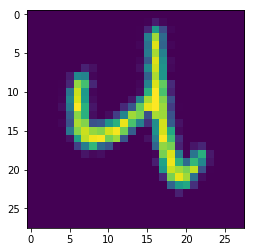

In [26]:
import matplotlib.pyplot as plt

epoch_x, epoch_y = data.train.next_batch(batch_size)
epoch_x_ = epoch_x.reshape((batch_size, 28, 28, 1))
epoch_y_ = one_hot_single(epoch_y)

plt.imshow(rotated_test_images_[6, :, :, 0])

/user2/mtc16/mtc1614/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


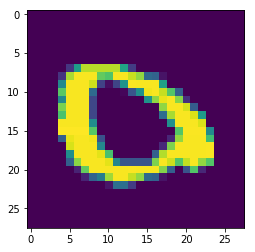

In [16]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
epoch_x_r = sess.run(rotation(X), feed_dict = {X : epoch_x.reshape((batch_size, 28, 28, 1))})
plt.imshow(epoch_x_r[2, :, :, 0])